In [1]:
from pathlib import Path

# Get the current working directory as a Path object
current_path = Path.cwd()
home_folder = 'evan_home'

# Traverse up the directory tree until you find the target folder
for parent in [current_path] + list(current_path.parents):
    if parent.name == home_folder:
        home_path = parent
        break
else:
    raise ValueError(f"Folder '{home_folder}' not found in the current working directory.")

print("Home Path:", home_path)
source_code_dir = home_path / 'Source_code'
dataset_dir = home_path / 'Dataset'


Home Path: c:\Users\evanlee\Documents\Bmi_NAS_evan\evan_home


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold, StratifiedKFold
from sklearn.metrics import make_scorer, matthews_corrcoef


In [4]:
import scanpy as sc

# adata = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\PBMC_Hao\GSE164378_Hao\Harmony_noZ\Hao_Harmony_test_no_scale.h5ad")
adata = sc.read_h5ad(dataset_dir / 'PBMC_Hao/GSE164378_Hao/Harmony_noZ/Hao_Harmony_test_no_scale.h5ad')
print('Original adata:', adata.shape)
adata.obs['celltype.l1'] = adata.obs['celltype.l1'].str.replace(' ', '_')
label = adata.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
print('all cell types:', types)
print('====================')
# del adata


Original adata: (161764, 33538)
all cell types: ['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


In [4]:
adata.obs.head()

,celltype.l1,celltype.l2,celltype.l3,Batch,donor,time,lane,Phase,nCount_ADT,nFeature_ADT,nCount_RNA,nFeature_RNA,leiden
L1_AAACCCAAGAAACTCA,Mono,CD14 Mono,CD14 Mono,Batch1,P2,7,L1,G1,7535,217,10823,2915,4
L1_AAACCCAAGACATACA,CD4_T,CD4 TCM,CD4 TCM_1,Batch1,P1,7,L1,G1,6013,209,5864,1617,2
L1_AAACCCACAACTGGTT,CD8_T,CD8 Naive,CD8 Naive,Batch1,P4,2,L1,S,6620,213,5067,1381,5
L1_AAACCCACACGTACTA,NK,NK,NK_2,Batch1,P3,7,L1,G1,3567,202,4786,1890,3
L1_AAACCCACAGCATACT,CD8_T,CD8 Naive,CD8 Naive,Batch1,P4,7,L1,G1,6402,215,6505,1621,5


## Read features

In [5]:
import os
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\feature_selection_k3")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/feature_selection_k3')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue

In [6]:
features_dict.keys()

dict_keys(['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T'])

In [7]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B,19,10
CD4_T,201,95
CD8_T,23,9
DC,50,23
Mono,50,20
NK,33,17
other,5,3
other_T,247,112


## Build classifiers (K-fold CV)

In [11]:
import pickle

def LR_kfold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # Kfold cross validation
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1_score': 'f1',
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',  # PR AUC
        'mcc': make_scorer(matthews_corrcoef)
    }

    print('Cross validation...')
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    # cv_results = cross_validate(clf, X, y, cv=cv, scoring=scoring, n_jobs=32)
    ## Use training set in cross_validate()
    cv_results = cross_validate(clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=32)

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1_score'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_average_precision'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]

    return clf, mean_metrics

In [ ]:
cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics = pd.DataFrame(columns=cols)
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics = LR_kfold(adata, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    
    # Append metrics to all_metrics
    all_metrics.loc[celltype] = metrics

    # output LR model as pickle
    # filename = f'LR_{celltype}_Harmony_l1.pkl'
    # with open(filename, 'wb') as f:
    #     pickle.dump(clf, f)


K-fold CV for: B
Cross validation...
[0.9996213623542243, 0.9981883149839714, 0.997373188405797, 0.9977795945336936, 0.9999872974029607, 0.9998366320033842, 0.9975733207784373]
K-fold CV for: CD4_T
Cross validation...
[0.9699098114991154, 0.9405974882025712, 0.9407030224794705, 0.9406445227319289, 0.9940973567564262, 0.9827918356646451, 0.9204961760984652]
K-fold CV for: CD8_T
Cross validation...
[0.9757362235377418, 0.9457842028798703, 0.8973251533742331, 0.92091423928482, 0.9917231719799202, 0.9680527194458424, 0.9070355540689841]
K-fold CV for: DC
Cross validation...
[0.9985086282671457, 0.9708313980434987, 0.9616864111498258, 0.9662257743345352, 0.9998589569085745, 0.9943252247660392, 0.9654805856747224]
K-fold CV for: Mono
Cross validation...
[0.9936249614321492, 0.9838887585189402, 0.9952561039983626, 0.9895395935728072, 0.9988006430235676, 0.9954641548991006, 0.9849890935094591]
K-fold CV for: NK
Cross validation...
[0.9929372352304565, 0.9704749030230169, 0.9682540618635207, 0.

In [10]:
# cv_results = cross_validate(clf, X, y, cv=cv, scoring=scoring, n_jobs=32)
# all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.999617,0.998187,0.997319,0.997753,0.999989,0.999862,0.997543
CD4_T,0.969894,0.940921,0.940270,0.940592,0.994114,0.982869,0.920434
CD8_T,0.975644,0.945647,0.896855,0.920603,0.991762,0.968353,0.906675
DC,0.998547,0.971636,0.962665,0.967121,0.999861,0.994380,0.966394
Mono,0.993670,0.983770,0.995532,0.989616,0.998748,0.995133,0.985099
NK,0.992860,0.970659,0.967370,0.969006,0.998694,0.994418,0.964977
other,0.991772,0.932531,0.661249,0.773686,0.933482,0.800392,0.781499
other_T,0.989954,0.909886,0.844304,0.875827,0.993489,0.934684,0.871284


In [13]:
# cv_results = cross_validate(clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=32)
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.999621,0.998188,0.997373,0.997780,0.999987,0.999837,0.997573
CD4_T,0.969910,0.940597,0.940703,0.940645,0.994097,0.982792,0.920496
CD8_T,0.975736,0.945784,0.897325,0.920914,0.991723,0.968053,0.907036
DC,0.998509,0.970831,0.961686,0.966226,0.999859,0.994325,0.965481
Mono,0.993625,0.983889,0.995256,0.989540,0.998801,0.995464,0.984989
NK,0.992937,0.970475,0.968254,0.969359,0.998744,0.994620,0.965371
other,0.991755,0.932269,0.660850,0.773252,0.933132,0.800238,0.781107
other_T,0.989908,0.909961,0.842942,0.875135,0.993403,0.933653,0.870595


In [ ]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\LR_likelihood")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/LR_likelihood')
# save metrics
all_metrics.index = types
all_metrics.to_csv('LR_metrics_L1_k3_stratifiedKF.csv')

## Plot classifier K-fold CV metrics

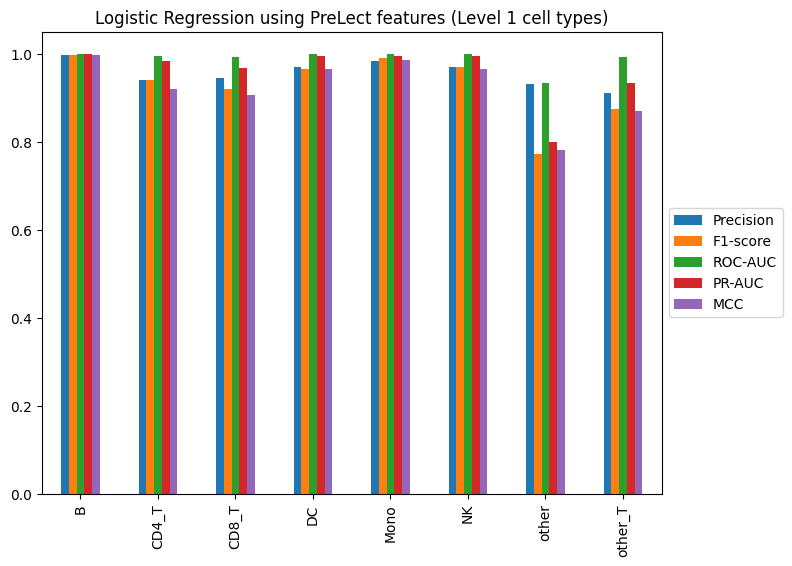

In [15]:
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']

# Plot metrics for each celltype
ax = all_metrics[cols].plot.bar(rot=90, figsize=(8,6), title='Logistic Regression using PreLect features (Level 1 cell types)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Get likelihood from LR model

In [16]:
def LR_likelihood_pred_prob(data, all_features_dict, celltype):
    print('====================')
    print('Celltype:', celltype)
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # likelihood of the positive class for each observation
    likelihood = clf.predict_proba(X)[:, 1]  # >0.5: predict celltype, <0.5: predict not celltype
    print('likelihood > 0.5:', sum(likelihood > 0.5))  # decision_scores > 0 的有幾個

    return likelihood


In [17]:
celltype = 'B'
B_likelihood = LR_likelihood_pred_prob(adata, features_dict, celltype)
B_likelihood.shape

Celltype: B
likelihood > 0.5: 13790


(161764,)

In [18]:
B_likelihood[:5]

array([2.97352922e-05, 1.47745973e-05, 3.57677267e-05, 8.27807240e-06,
       1.02407501e-05])

In [19]:
likelihood_dict = {}
for celltype in types:
    likelihood_dict[celltype] = LR_likelihood_pred_prob(adata, features_dict, celltype)

Celltype: B
likelihood > 0.5: 13790
Celltype: CD4_T
likelihood > 0.5: 41024
Celltype: CD8_T
likelihood > 0.5: 24135
Celltype: DC
likelihood > 0.5: 3548
Celltype: Mono
likelihood > 0.5: 49593
Celltype: NK
likelihood > 0.5: 18593
Celltype: other
likelihood > 0.5: 2447
Celltype: other_T
likelihood > 0.5: 6294


In [20]:
# turn likelihood_dict into dataframe
likelihood_df = pd.DataFrame(likelihood_dict)
likelihood_df.head()

,B,CD4_T,CD8_T,DC,Mono,NK,other,other_T
0,0.000030,0.000019,0.000110,4.338845e-05,0.967427,0.000031,0.002133,4.302029e-07
1,0.000015,0.997751,0.000674,9.925294e-09,0.000041,0.000140,0.003106,1.215517e-04
2,0.000036,0.007960,0.998966,1.792313e-08,0.000030,0.000050,0.002087,4.259559e-02
3,0.000008,0.000010,0.000316,2.467536e-09,0.000024,0.999984,0.003943,1.572427e-05
4,0.000010,0.000222,0.999026,2.558236e-09,0.000015,0.000012,0.003672,2.277843e-03


In [21]:
likelihood_df.shape

(161764, 8)

In [22]:
# row sum
likelihood_df.sum(axis=1)


0         0.969794
1         1.001848
2         1.051725
3         1.004302
4         1.005236
            ...   
161759    1.010208
161760    1.002285
161761    1.011929
161762    0.979293
161763    0.986322
Length: 161764, dtype: float64

In [ ]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_batch_noZ\Level1\LR_likelihood")
os.chdir(source_code_dir / 'PBMC_Hao_batch_noZ/Level1/LR_likelihood')
likelihood_df.to_csv('L1_likelihood_df_k3.csv')

## Assign the celltype with the largest likelihood (no odds ratio)

In [23]:
largest_values = []
largest_columns = []
assignments = []
for index, row in likelihood_df.iterrows():
    # find largest value and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    largest_values.append(largest_value)
    largest_columns.append(largest_column)

    assign = largest_column
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns, 'Assignment': assignments})
result_df.shape


(161764, 3)

In [ ]:
result_df.head(20)

## Confusion heatmap

In [23]:
import pandas as pd

# Get the true labels
true_labels = adata.obs['celltype.l1'].tolist()

# Get the predicted labels
predicted_labels = result_df['Assignment'].tolist()

# Create the confusion matrix
cm = pd.crosstab(true_labels, predicted_labels, rownames=['True'], colnames=['Predicted'], margins=False)

# reorder columns
# cm = cm.reindex(types + ['Uncertain'], axis=1)

# replace NaN with 0
cm = cm.fillna(0)
cm = cm.astype(int)


In [ ]:
cm

In [25]:
cm.to_csv('likelihood_assignment_confusion_matrix_k3.csv')

## Plot confusion matrix

In [3]:
import os
os.chdir('./LR_likelihood')
cm = pd.read_csv('likelihood_assignment_confusion_matrix_k3.csv', index_col=0)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LR Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
row_sum = cm.sum(axis=1)
row_sum


In [ ]:
cm_proportion = cm.div(row_sum, axis=0)
cm_proportion *= 100
plt.figure(figsize=(10, 10))
sns.heatmap(cm_proportion, fmt=".1f", annot=True, cmap='Blues')
plt.title('LR Prediction Confusion Matrix (Proportion %)')
plt.savefig('cm_plot.png', dpi=300)
plt.show()

## Calculate accuracy

In [ ]:
accuracy = sum(np.diag(cm)) / cm.values.sum()
accuracy

In [ ]:
cm.values.sum()